
# In search of an Optimal FAANG Portfolio with Monte Carlo Method
***


### <font color=green>What is an Optimal Portfolio?</font>

According to the well-known theory of Portfolio Selection by Harry Markowitz, there is an optimal portfolio that could be designed with a perfect balance between risk and return.

The optimal portfolio does not simply include securities with the highest potential returns or low-risk securities. The optimal portfolio aims to balance securities with the greatest potential returns with an acceptable degree of risk or securities with the lowest degree of risk for a given level of potential return.


__There are several objectives for an optimal portfolio, we will focus on a portfolio with maximized Sharpe Ratio here.__

_Sharpe Ratio = Expected Returns [Expected Asset Returns - Risk-free Returns] / Volatility [Standard Deviation of the Asset Excess Return]_

### <font color=red> What is a Monte Carlo Method?</font>
A Monte Carlo Simulation Method takes the variable that has uncertainty and assigns it a random value. The model is then run and a result is provided. This process is repeated again and again while assigning the variable in question with many different values. Once the simulation is complete, the results are averaged together to provide an estimate. [Investopedia]


### <font color=blue> What is a FAANG Portfolio?</font>
A portfolio of five big tech companies that show unprecedented growth: Facebook (FB.O), Amazon (AMZN.O), Apple (AAPL.O), Netflix (NFLX.O) and Google (GOOG.O).



#### We will identify the Optimal Weight Allocation for a FAANG Portfolio


In [7]:
# For Eikon Data API
import refinitiv.dataplatform.eikon as ek
ek.set_app_key('DEFAULT_CODE_BOOK_APP_KEY')

import numpy as np
import seaborn as sns
from datetime import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt

#### Daily Arithmetic Returns of FAANG over the past 2 years through Eikon Data API

CLOSE,FB.O,AMZN.O,AAPL.O,NFLX.O,GOOG.O
Date,,,,,
2019-07-08,195.76,1952.32,50.0050,376.16,1116.35
2019-07-09,199.21,1988.30,50.3100,379.93,1124.83
2019-07-10,202.73,2017.41,50.8075,381.00,1140.48
2019-07-11,201.23,2001.07,50.4375,379.50,1144.21
2019-07-12,204.87,2011.00,50.8250,373.25,1144.90
...,...,...,...,...,...
2021-06-29,351.89,3448.14,136.3300,533.50,2520.37
2021-06-30,347.71,3440.16,136.9600,528.21,2506.32
2021-07-01,354.39,3432.97,137.2700,533.54,2527.37


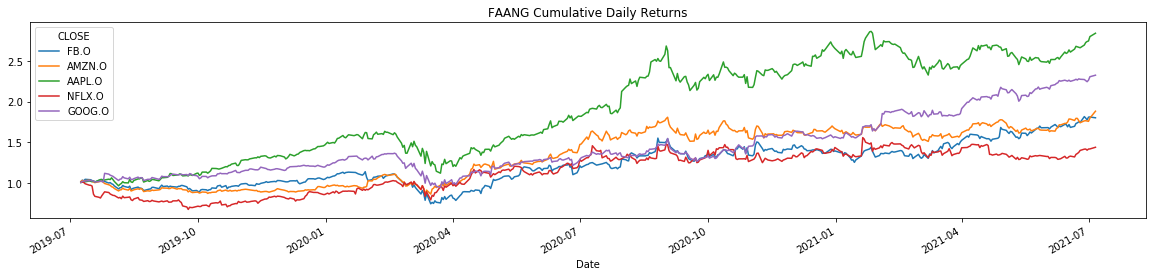

In [10]:
# define variable for latest closing day
end_date = dt.now()

faang = ek.get_timeseries(["FB.O","AMZN.O","AAPL.O","NFLX.O","GOOG.O"], start_date = datetime(end_date.year - 2,end_date.month,end_date.day),end_date =end_date, interval="daily", fields="CLOSE")
faang_pct = faang.pct_change(1) 
faang_cum = (faang_pct +1).cumprod()
faang_cum.plot(title='FAANG Cumulative Daily Returns',figsize=(20,4))
faang

#### Correlation Matrix between FAANG

The correlation coefficient is measured on a scale from -1 to 1. 
A correlation coefficient of 1 indicates a perfect positive correlation between the prices of two stocks, meaning the stocks always move the same direction by the same amount.

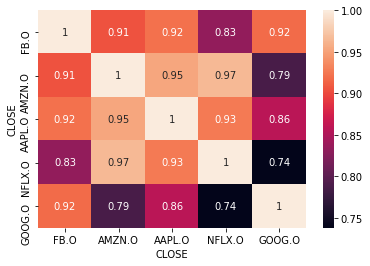

In [11]:
sns.heatmap(faang.corr(),annot=True)

#### Daily Logarithmic Returns and Distributions

In [12]:
faang_logreturn = np.log(faang/faang.shift(1))
faang_logreturn.head()

CLOSE,FB.O,AMZN.O,AAPL.O,NFLX.O,GOOG.O
Date,,,,,
2019-07-08,NaN,NaN,NaN,NaN,NaN
2019-07-09,0.017470,0.018262,0.006081,0.009972,0.007567
2019-07-10,0.017515,0.014535,0.009840,0.002812,0.013817
2019-07-11,-0.007427,-0.008132,-0.007309,-0.003945,0.003265
2019-07-12,0.017927,0.004950,0.007653,-0.016606,0.000603


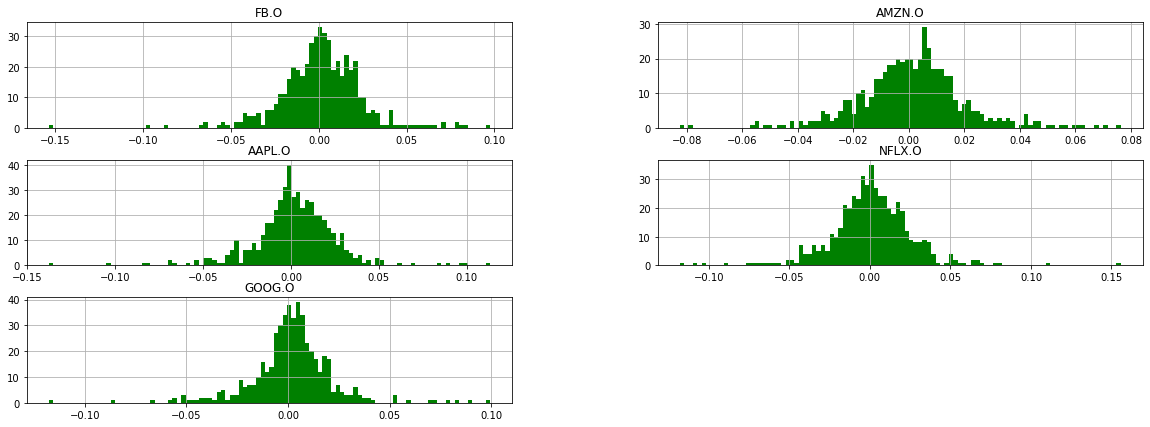

In [13]:
faang_logreturn.hist(bins=100,figsize=(20,7),color='green');
plt.rcParams.update({'figure.autolayout': True})

#### Generating FAANG Portfolios of Random Weight Allocations

In [29]:
# Create blank arrays to place random weight allocations
iterations = 5000
weight_combination = np.zeros((iterations,len(faang.columns)))
expected_returns = np.zeros(iterations)

# Assume Risk-free Rates = 3%
risk_free_returns = 0.03
expected_returns = expected_returns - risk_free_returns
volatility = np.zeros(iterations)
sharpe_ratio = np.zeros(iterations)

In [30]:
for i in range(iterations):
    
    random_weights = np.array(np.random.random(5))
    random_norm_weights = random_weights / np.sum(random_weights)
    weight_combination[i,:] = random_norm_weights
    expected_returns[i] = np.sum((faang_logreturn.mean() * random_norm_weights) *252) # 252 trading days in a year
    volatility[i] = np.sqrt(np.dot(random_norm_weights.T, np.dot(faang_logreturn.cov() * 252, random_norm_weights)))
    sharpe_ratio[i] = expected_returns[i]/volatility[i]

Optimal_ret = expected_returns[sharpe_ratio.argmax()]
Optimal_vol = volatility[sharpe_ratio.argmax()]

Optimal_ret

0.4638090639519934

#### The Optimal FAANG Portfolio with Maximized Sharpe Ratio

,FB.O,AMZN.O,AAPL.O,NFLX.O,GOOG.O
Weight,0.030124,0.010919,0.485339,0.010594,0.463024


Expected Returns,Volatility,Maximized Sharpe Ratio
0.463809,0.320269,1.448187


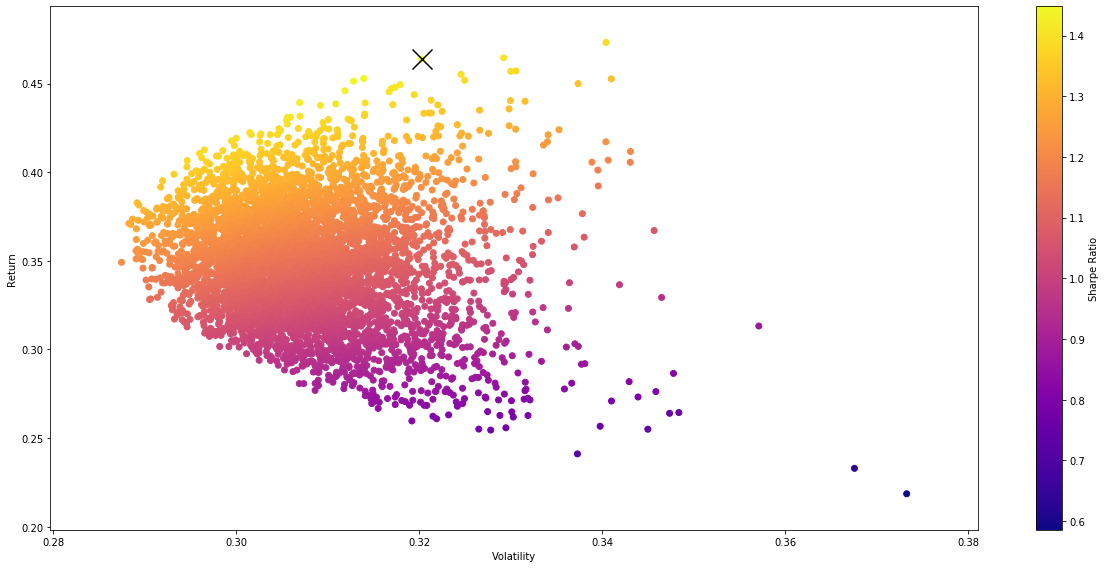

In [41]:
plt.figure(figsize=(17,8))
plt.scatter(volatility,expected_returns,c=sharpe_ratio,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Marking the point with maximized Sharpe Ratio
plt.scatter(Optimal_vol,Optimal_ret,marker='x',c='black',s=400)

#The Optimal Weight Allocation on FAANG
Optimal_weights = pd.DataFrame(weight_combination[sharpe_ratio.argmax(),:]).T
Optimal_weights.columns = ['FB.O','AMZN.O','AAPL.O','NFLX.O','GOOG.O']
Optimal_weights.index = ['Weight']
display(Optimal_weights)

df = pd.DataFrame({
    'Expected Returns': [Optimal_ret],
    'Volatility': [Optimal_vol],
    'Maximized Sharpe Ratio': [sharpe_ratio.max()]
})

display(df.style.hide_index())
